<a href="https://colab.research.google.com/github/Ahmadrezauf/IML_Projects/blob/master/task_4/main_project4_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
import numpy as np
import os
import random

from google.colab import files
import io
import time

import pdb
import cv2
import matplotlib.pyplot as plt

import keras.backend as K
from keras import Sequential

from keras.layers import Dense, Dropout, Activation, SimpleRNN, LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Embedding
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Input, Layer

from keras.regularizers import l2

from keras.models import Model

from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import Callback,ModelCheckpoint, EarlyStopping
from keras import initializers

from matplotlib import pyplot as plt

Using TensorFlow backend.


### Mounting drive and changing dir

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
import os
workDir = '/content/drive/My Drive/ETHZ/IML/Project_4' #input('input the working directory: ')
os.chdir(workDir)

Mounted at /content/drive


## Hyperparameters

In [0]:
# desired image size for input to layer in format (w,h)
imgSize = (100,100)
# embedding size
emb_size = 50
# margin for triplet loss
alpha = 1.0

# Loading data

## Importing image tensor

In [37]:
if os.path.exists('img_list.pickle'):
  pickle_in = open( "img_list.pickle", "rb" )
  food_images = pickle.load(pickle_in)
  pickle_in.close()
  print("The image array was successfully loaded")
else:
  num_food_images = 10000
  path = 'food/'
  imageSize = (450,300)

  temp = np.zeros([imageSize[0],imageSize[1]])

  food_images = [temp]*num_food_images

  for indx in range(0, num_food_images):

    # reading in images and adding it to array
    fileName = f'{path}{indx:05d}.jpg'
    # color correct from BGR to RGB 
    img = cv2.imread(fileName)
    # resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resize image
    img = cv2.resize(img, imageSize)
    # appending image
    food_images[indx] = img

    if indx%100 == 0:
      print(f'The progress is {round(indx/num_food_images*100,1)} %')

  saveY = input('Do you want to save the generated array? y/n')
  if saveY == 'y':
    pickle_out = open("img_list.pickle","wb")
    pickle.dump(food_images, pickle_out)
    pickle_out.close()
    print('The image array was successfully saved')
  else:
    print('The image array was NOT saved')

The image array was successfully loaded


## Importing training and testing triplets

In [0]:
D_train = pd.read_csv('train_triplets.txt', header = None, delim_whitespace=True)
D_test = pd.read_csv('test_triplets.txt', header = None, delim_whitespace=True)

train_triplets = np.array(D_train)
test_triplets = np.array(D_test)

num_train_triplets = np.shape(D_train)[0]
num_test_triplets = np.shape(D_test)[0]

# k-fold

In [39]:
# splitting data triplets
k_fold = 5

from sklearn.model_selection import KFold
kf = KFold(n_splits = k_fold, shuffle=True, random_state=1)

X = np.array(D_train)
# specify pseudo classification for split function
y = np.ones(X.shape[0])

k_index = list(kf.split(X,y))
k_index = np.array(k_index)

# visualize first k fold validation with training set
X[k_index[0][0],:]

array([[2461, 3450, 2678],
       [2299, 2499, 4987],
       [4663, 1056, 3029],
       ...,
       [3255, 4844, 4334],
       [2136, 4619,  161],
       [2509, 2552, 3406]])

In [0]:
# defining data
fold = X[k_index[0][0],:]
validate = X[k_index[0][1],:]

## function definitions

In [0]:
def create_batch(fold, batch_size=256, toSize = (450,300), flatten = True):
    
    if flatten:
      x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    else:
      x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])
          
    # get random samples from train triplets
    for i in range(0, batch_size):
        # preprocessing

        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, fold.shape[0]-1)
        triplet = fold[random_index]

        # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues

        x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
        x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
        x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

        if flatten:
          x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
          x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
          x_negative = np.reshape(x_negative, np.prod(x_negative.shape))
             
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

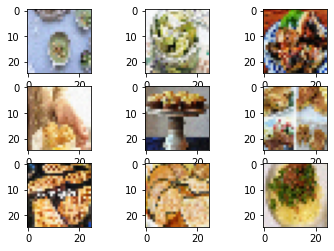

In [42]:
# Example how to use function

tr = create_batch(fold, batch_size=3, toSize = (25,25), flatten = False)

for n in range(0,len(tr[0])):
  for i in range(0,3):
    plt.subplot(len(tr[0]),3, 3*n + i+1)
    plt.imshow(tr[i][n])

In [0]:
def data_generator(fold, batch_size=256, toSize = (10,10), flatten=True):
    while True:
        x = create_batch(fold, batch_size, toSize, flatten)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [0]:
def run_through(fold, toSize = (450,300), flatten = True):
    
    batch_size = len(fold)

    if flatten:
      x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
      x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    else:
      x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
      x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])

    
    # get random samples from train triplets
    for i in range(0, len(fold)):
        # preprocessing

        # We need to find an anchor, a positive example and a negative example
        triplet = fold[i]

        # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues

        x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
        x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
        x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

        if flatten:
          x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
          x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
          x_negative = np.reshape(x_negative, np.prod(x_negative.shape))
             
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative

        # yield [x_anchors, x_positives, x_negatives]
        
    return [x_anchors, x_positives, x_negatives]

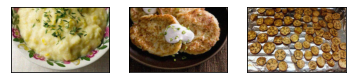

In [45]:
def plot_triplets(examples, imgSize):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (imgSize[1], imgSize[0], 3)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

examples = create_batch(fold,1)
plot_triplets(examples,(450,300))

# Defining Model & network

## Embedding layer

In [0]:
# import tensorflow as tf

# embedding_model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(emb_size, activation='relu', input_shape=(imgSize[0]*imgSize[1]*3,)),
#     tf.keras.layers.Dense(emb_size, activation='sigmoid')
# ])

# embedding_model.summary()

## Embedding layer with convolution

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

embedding_model = keras.Sequential()
embedding_model.add(keras.Input(shape=(imgSize[1], imgSize[0], 3))) 

embedding_model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
embedding_model.add(layers.MaxPooling2D(2))

embedding_model.add(layers.Conv2D(32, 3, strides=2, activation="relu"))
embedding_model.add(layers.MaxPooling2D(2))

# embedding_model.add(layers.GlobalMaxPooling2D())

embedding_model.add(layers.Flatten())

embedding_model.add(layers.Dense(emb_size, activation='sigmoid'))


In [48]:
embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                40050     
Total params: 51,730
Trainable params: 51,730
Non-trainable params: 0
__________________________________________________

## Siamese network

In [49]:
input_anchor = tf.keras.layers.Input(shape=(imgSize[1],imgSize[0],3))
input_positive = tf.keras.layers.Input(shape=(imgSize[1],imgSize[0],3))
input_negative = tf.keras.layers.Input(shape=(imgSize[1],imgSize[0],3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           51730       input_6[0][0]                    
                                                                 input_7[0][0]              

## Triplet loss

In [0]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    triplet_loss = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    loss = tf.reduce_mean(triplet_loss)
    return loss

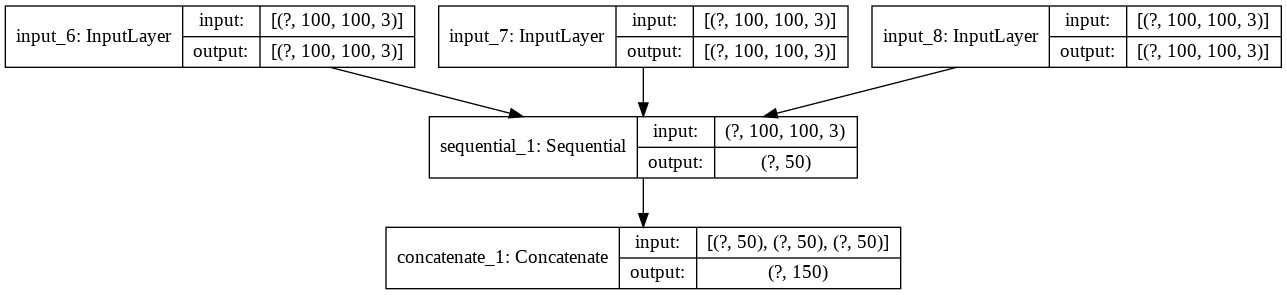

In [51]:
tf.keras.utils.plot_model(net, show_shapes=True, show_layer_names=True)

# Training & saving network

In [0]:
#from pca_plotter import PCAPlotter
import math

batch_size = 64
epochs = 50
steps_per_epoch = math.floor(fold.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adamax')

result =  net.fit(
    data_generator(fold, batch_size, imgSize,flatten=False),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/50
726/743 [============================>.] - ETA: 4s - loss: 0.9502

In [0]:
# saving as pickle object
# pickle_out = open("net.pickle","wb")
# pickle.dump(result, pickle_out)
# pickle_out.close()

import keras.losses
keras.losses.custom_loss = triplet_loss

from keras.models import load_model
import datetime
now = datetime.datetime.now()

description = input('optional file description: ')

filepath = f'{workDir}/models/{round(now.timestamp())}_sb_model_{description}.h5'
print(filepath)
net.save(filepath)

# Test predictions & save results

In [0]:
# optionally loading a model
from tensorflow.keras.models import load_model

inp = input('Select model to run: ')

net_saved = load_model(inp, custom_objects={'triplet_loss': triplet_loss})

In [0]:
# function for transforming predicted embeddings to required prediction 0 or 1
# anchor: dish A, positive: dish B, negative: dish C
# if distance A to B < A to C then A is more similar to B than to C -> return 1

def similar_dish(prediction):
  out = [0]*len(prediction)
  for idx, vec in enumerate(prediction):
    anchor, positive, negative = vec[:emb_size], vec[emb_size:2*emb_size], vec[2*emb_size:]
    positive_dist = np.mean(np.square(anchor - positive))
    negative_dist = np.mean(np.square(anchor - negative))

    if positive_dist < negative_dist:
      out[idx] = 1
    else:
      out[idx] = 0
  return out

In [0]:
# less memory intense way of creating predictions
def predict_vec(fold, batch_size = 1000, toSize = (450,300), flatten = True):

  if flatten:
    x_anchors = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    x_positives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
    x_negatives = np.zeros((batch_size, toSize[0]*toSize[1]*3))
  else:
    x_anchors = np.zeros([batch_size, toSize[1], toSize[0], 3])
    x_positives = np.zeros([batch_size, toSize[1], toSize[0], 3])
    x_negatives = np.zeros([batch_size, toSize[1], toSize[0], 3])

  predictions = []
  c = 0
  totlen=0
  # get random samples from train triplets
  for i in range(0, len(fold)):

      if i%500 == 0:
        print(f'The progress is {round(i/len(fold)*100,1)} %')
      # preprocessing

      # We need to find an anchor, a positive example and a negative example
      triplet = fold[i]

      # reshaping, normalizing and flattening images --> this will take more time than pre-processed data, but will eliminate RAM issues

      x_anchor = cv2.resize(food_images[triplet[0]],toSize)/255.0
      x_positive = cv2.resize(food_images[triplet[1]],toSize)/255.0
      x_negative = cv2.resize(food_images[triplet[2]],toSize)/255.0

      if flatten:
        x_anchor = np.reshape(x_anchor, np.prod(x_anchor.shape))
        x_positive = np.reshape(x_positive, np.prod(x_positive.shape))
        x_negative = np.reshape(x_negative, np.prod(x_negative.shape))

      x_anchors[c] = x_anchor
      x_positives[c] = x_positive
      x_negatives[c] = x_negative

      if c >= (batch_size-1) or i == (len(fold)-1):
        if i == (len(fold)-1):
          print(f'End with c {c}')
        print(f'i is {i}, Predicting...')
        # print(x_anchors[-1])        
        X = [x_anchors[0:c], x_positives[0:c], x_negatives[0:c]]
        print(np.array(X).shape)
        vec = net.predict(X)
        predictions.append(similar_dish(vec))

        # predictions.append(similar_dish(vec))
        print('End of predictions...')

        totlen = totlen + len(vec)

        # resetting c
        c = -1

        # break

      c = c + 1

  pred_flat = []
  for li in predictions:
    for elem in li:
      pred_flat.append(elem)
  
  print(f' The length of the vector is: {totlen}')

  return pred_flat

In [0]:
#--> debug predict_vec (the output sizes are off by 1)
# pr_val = predict_vec(validate, batch_size = 501, toSize = imgSize, flatten=False)

In [0]:
# # There is still a discrepancy
# print(len(outVec))
# print(len(validate))

In [0]:
# # percentage accuracy
# perc_accuracy = round(np.sum(pr_val)/len(pr_val)*100,1)
# print(f'The accurate predictions from the validation set is {perc_accuracy} %')

In [0]:
#deprecated

# X = run_through(validate, toSize = imgSize, flatten=False)

# predicted_embeddings = net.predict(X)
# predicted_embeddings.shape

# making predictions for the test set in the first fold
# sv_f1 = [similar_dish(emb) for emb in predicted_embeddings]
# perc_accurate = round(np.sum(sv_f1)/len(sv_f1)*100,1)
# print(f'The percentage of accurate predictions for the first fold test set is: {perc_accurate} %')

In [0]:
# pr_test = predict_vec(D_test, batch_size = 1000, toSize = imgSize, flatten=False)

In [0]:
# # percentage accuracy
# positive_given = round(np.sum(pr_test)/len(pr_test)*100,1)
# print(f'Predicted positive images given is {positive_given} %')

In [0]:
# deprecated
D_test = np.array(D_test)
X = run_through(D_test, toSize = imgSize, flatten=False)

predicted_embeddings = net.predict(X)
predicted_embeddings.shape

In [0]:
# # making predictions for the test set in the first fold
sv_pr = similar_dish(predicted_embeddings)
perc_accurate = round(np.sum(sv_pr)/len(sv_pr)*100,1)
print(f'The percentage of accurate predictions for the test set is: {perc_accurate} %')
print(np.array(sv_pr).shape)

In [0]:
description = input('Add an optional description to the result file: ')
filepath = f'{workDir}/results/{round(now.timestamp())}_sb_result_{description}.txt'
np.savetxt(filepath, sv_pr, fmt='%i', )